In [1]:
%matplotlib inline

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy.stats import stats, gaussian_kde
from sklearn import linear_model, naive_bayes

from bg_analysis import data_cleaning, time_analysis

In [3]:
glucose_path = 'blood-glucose.csv'
motion_path = 'motion.tsv'
model_path = 'glucose_predictor.model'

In [4]:
glucose_table = pd.read_csv(glucose_path, header=None, names=['time', 'glucose'])
motion_table = data_cleaning.read_motion_tsv(motion_path)
motion_table['time'] = motion_table['time'].map(data_cleaning.motion_timestring_to_datetime)
motion_table = motion_table.set_index('time')
glucose_table['time'] = glucose_table['time'].map(data_cleaning.glucose_timestring_to_datetime)

In [5]:
start_time = glucose_table['time'][0]
print start_time

2017-05-23 00:00:00


In [6]:
engine = time_analysis.AnalysisEngine(
    initial_time=start_time,
    log_interval=timedelta(minutes=15)
)
for time_state_tup in motion_table.iterrows():
    engine.process_line(time_state_tup)

In [7]:
time_walking = engine.get_accumulated_table(
    bin_size=timedelta(days=2),
    activities=['walking']
)['walking']
time_walking = time_walking.map(timedelta.total_seconds)/(60 * 60) # convert to hours

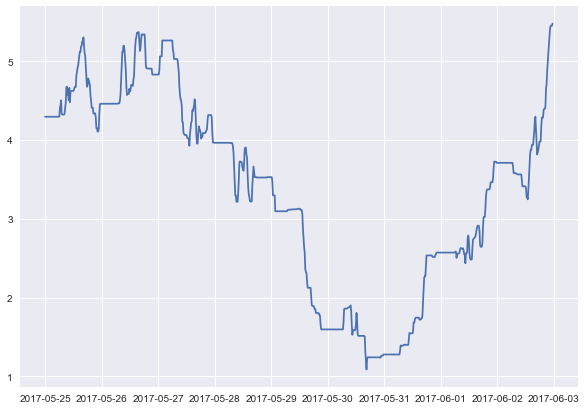

In [8]:
plt.figure(figsize=(10,7))
plt.plot(time_walking)

In [9]:
glucose_no_nan = glucose_table.dropna(axis=0, how='any')

In [10]:
glucose_axis_full = (glucose_table['time'] - start_time).map(timedelta.total_seconds)
glucose_axis_nonan = (glucose_no_nan['time'] - start_time).map(timedelta.total_seconds)
interp_glucose = np.interp(glucose_axis_full, glucose_axis_nonan, glucose_no_nan['glucose'])
interp_glucose = pd.Series(interp_glucose, index=glucose_table['time'])

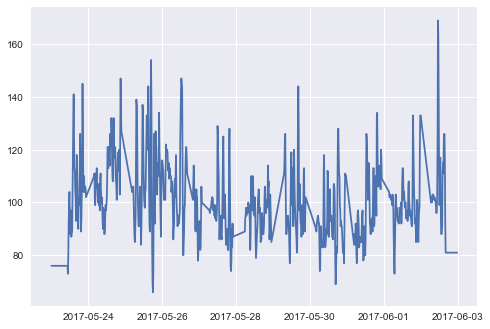

In [11]:
plt.plot(interp_glucose)

In [12]:
glucose_std = time_analysis.map_to_window(np.std, interp_glucose, window_size=48*60/15)
glucose_std = pd.Series(glucose_std[:-1], index=time_walking.index, name='glucose std')

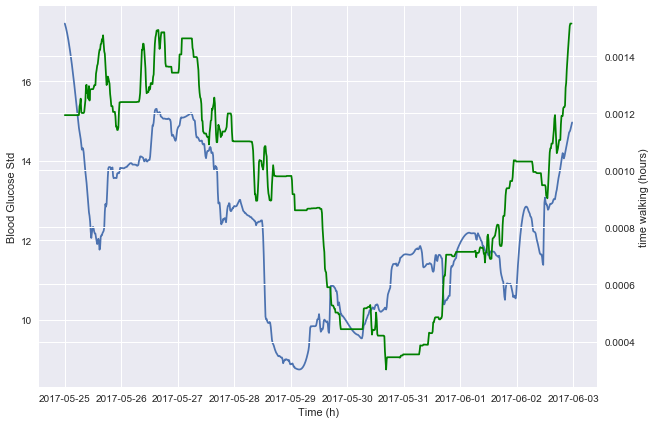

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(glucose_std)
plt.ylabel('Blood Glucose Std')
plt.xlabel('Time (h)')
twin_ax = plt.twinx()
twin_ax.plot(time_walking[:-1]/(60*60), 'g')
plt.ylabel('time walking (hours)')

In [14]:
stats.pearsonr(glucose_std, time_walking)

(0.68443070232420156, 2.7975718329398012e-120)

The standard deviation of blood glucose levels and the total time spent walking are positively correlated with a pearson's correlation coefficient of 0.684. This indicates that there is a reasonable linear relationship between a person's blood glucose fluctionations and the amount of time they have spent walking in the past 48 hours.

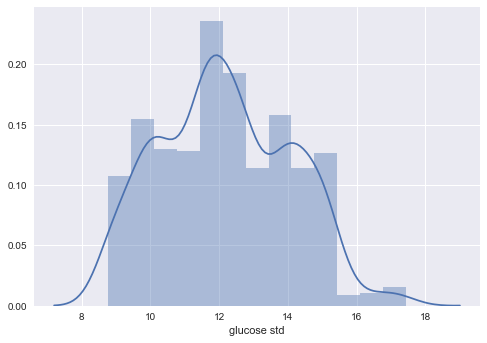

In [15]:
sns.distplot(glucose_std)

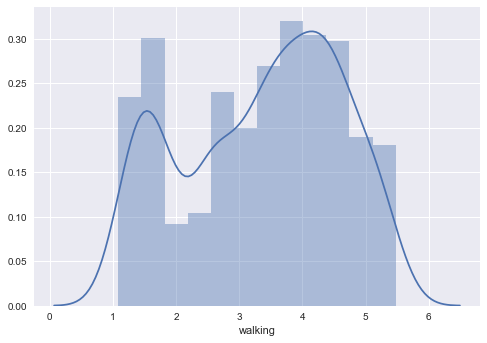

In [16]:
sns.distplot(time_walking)

In [17]:
def as_vector(series):
    #hacky sln for my 1d data
    return series.as_matrix()[..., np.newaxis]

In [18]:
# Data for training is from glucose_no_nan and the corresponding points in time_walking_series
valid_data_index = time_walking.index.intersection(glucose_no_nan['time'])
shuffled_index = np.random.permutation(valid_data_index)
training_index = shuffled_index[:-100]
testing_index = shuffled_index[-100:]
valid_walking = time_walking[valid_data_index]
valid_glucose_std = glucose_std[valid_data_index]
training_walking = as_vector(time_walking[training_index])
training_glucose_std = as_vector(glucose_std[training_index])
testing_walking = as_vector(time_walking[testing_index])
testing_glucose_std = as_vector(glucose_std[testing_index])

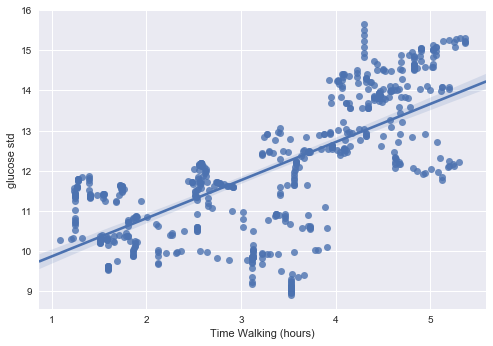

In [19]:
sns.regplot(x=valid_walking, y=valid_glucose_std)
plt.xlabel('Time Walking (hours)')

In [20]:
reg_model = linear_model.LinearRegression()
reg_model.fit(training_walking, training_glucose_std)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
test_output = reg_model.predict(testing_walking)

(8, 16)

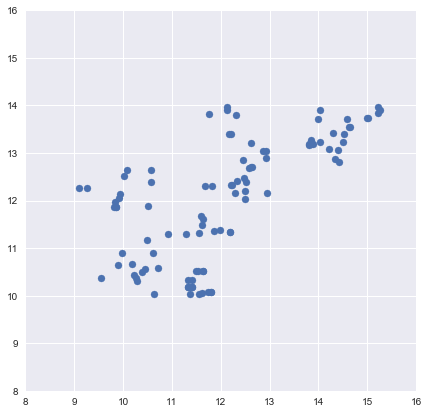

In [22]:
plt.figure(figsize=(7, 7))
plt.scatter(testing_glucose_std, test_output)
plt.xlim(8, 16)
plt.ylim(8, 16)

My model tends to underestimate the blood glucose standard deviation when it is high. However, it correctly places datapoints into categories > 12.5 and < 12.5

In [23]:
mse = sum((test_output - testing_glucose_std)**2)
rms = mse**0.5
print mse
print rms

[ 144.79761199]
[ 12.03318794]


In [24]:
gnb = naive_bayes.GaussianNB()
gnb.fit(training_walking, training_glucose_std.ravel() > 12.5)
print gnb.score(testing_walking, testing_glucose_std.ravel() > 12.5)

0.89


In [25]:
print "Saving model to " + model_path
f = open(model_path, 'w')
pickle.dump(gnb, f)
f.close()

Saving model to glucose_predictor.model


In [26]:
most_recent = engine.get_most_recent_bin()
print most_recent
print most_recent['walking']

                         automotive cycling         running  \
2017-06-02 23:45:00 00:15:15.186888  0 days 00:00:23.034648   

                                stationary         walking  
2017-06-02 23:45:00 1 days 06:25:48.317094 05:28:39.442900  
2017-06-02 23:45:00   05:28:39.442900
Name: walking, dtype: timedelta64[ns]
